In [52]:
%matplotlib inline
import numpy as np

In [53]:
import matplotlib.pyplot as plt

In [54]:
import katarchive
import katdal as katfile
import katfile
import datetime

import logging
logging.root.setLevel(logging.ERROR)


In [55]:
#print katarchive.search_archive(startdate='01/01/2014',enddate='31/08/2015')


In [56]:
f = katarchive.search_archive(startdate='01/01/2014')
start = datetime.datetime.strptime(f[-1].__str__().split('\'')[3],'%Y-%m-%d %H:%M:%S %Z')
end = datetime.datetime.strptime(f[0].__str__().split('\'')[3],'%Y-%m-%d %H:%M:%S %Z')

Searched using: CAS.ProductTypeName:(KatFile) AND CAS.ProductTransferStatus:RECEIVED AND StartTime:[2013-12-31T22:00:00Z TO 2015-08-31T21:59:59Z]
Returning 7752 results


In [57]:
print 'First file in run: ' , start.isoformat()
print 'Last file in run: ' , end.isoformat()

First file in run:  2014-01-06T12:15:35
Last file in run:  2015-08-31T00:56:15


Only select observations that are longer than 1 hrs then extract the project id from the script parameters. If there is no project id then allocated No_project_id 

In [58]:
def findproj(text):
    found='Unknown'        # default
    chx=text.find('prop')
    if chx >0  :
        pr2=text[chx+11:chx+38].split()
        code=pr2[0]
        found=code.replace("=","")
    else:
        if text.find('aser') >0 or text.find('G9.62') >0 :
            found="Maser monitoring"
    chx=text.find('proj')
    if chx >0  :
        pr2=text[chx+11:chx+38].split()
        code=pr2[0]
        found=code.replace("=","")
    if found == 'Unknown':
        print text
    return found


In [59]:
sbd = []
pid = []
fnd = []
dud = []
antsd = []
scrd = []

for fi in f:
    if fi.metadata.Duration < 3600: #only pick hour long or greater observations for analysis
        continue
    # now try extract the project-id from the instruction-set string
    script = fi.metadata.InstructionSet
    """
    scrd.append(script)
    spl = script.split()
    for i,s in enumerate(spl):
        if u'--project-id' in s:
            if '=' in s: #some people use --project-id=yyyymmddNN-01 and some --project-id yyyymmddNN-01
                p = s.split('=')[-1]
            else:
                p = spl[i+1]
            break
        else:
            if u'G9.62' in s: # special case for the masers that dont have ids
                p = 'Maser'
                break
            p = 'No-project-id' 
    """ 
    p=findproj(script)
  
    # Odd fixes for strange cases
    if len(p) == 0:
        print script
        p='20141002MB-01'
        
    p=p.replace('--description','')
    p=p.replace('--','')
    
    sbd.append(fi.metadata.ExperimentID)
    pid.append(p)
    fnd.append(fi.metadata.Filename)
    dud.append(fi.metadata.Duration)
    antsd.append(len(fi.metadata.Antennas))


/home/kat/scripts/observation/image.py -b 180 -g 180 -t 900 -i 7200 /home/kat/comm/catalogues/SS433_cir_pol.csv --stow-when-done -f 1822 --project-id = 20141002MB-01 --horizon=15 -m 9000 --sb-id-code=20141003-0007 --description=SS433 --observer=Nadeem Oozeer
/home/kat/scripts/observation/rfi_scan.py --stow-when-done -m 3600 --sb-id-code=20140616-0012 --description=RFI SCAN --observer=Sean
/home/kat/scripts/observation/tipping_curve.py -z85 -f1822 --sb-id-code=20140616-0010 --description=Tipping Curve --observer=Nadeem
/home/kat/scripts/observation/spiral_holography_scan.py --tracktime 2 -f 1850 -b ant2,ant5,ant7 --scan-extent 40 --cycle-duration 7200 --num-cycles 1 --kind uniform Ori A --stow-when-done --observer=Mattieu --sb-id-code=20140616-0006 --description=L-band holography 20mm adjusted focus Ori A 1850 40degree field - ant2 ant5 ant7 --observer=Mattieu
/home/kat/scripts/observation/rfi_scan.py --stow-when-done -m 4500 --sb-id-code=20140615-0024 --description=RFI SCAN --observer=

In [60]:
pi = np.array(pid)
sb = np.array(sbd)
du = np.array(dud)
ants = np.array(antsd)

p_cent = (sum(du)/((end.toordinal()-start.toordinal())*24*3600))*100

print 'Percentage system usage: ', np.floor(p_cent),'%'


Percentage system usage:  77.0 %


In [61]:
a_id = []
a_time = []
for p in set(pi):
    ind = pi == p
    print "%-28s %8.2f" %(p,round(sum(du[ind])/3600,2))
    a_id.append(p)
    a_time.append(round(sum(du[ind])/3600,2))

20131015GB-02                   15.12
Unknown                        660.28
20140529GB-01                   12.63
20140520RA-01                   51.62
201410161NO-01                  39.09
20140513DL-01                  119.88
20140122RC-01                  175.96
20150522RA-01                   24.10
20141002MB-01                  145.33
20150619TF-01                   81.57
20140624CC-01                  185.86
20150210SS-01                  639.76
20150120TF-01                   22.35
COMM_Noise                       4.73
COMM_bandpass_SG                24.16
COMMTEST                       626.18
20140527TF-01                  372.74
20150127CC-01                    8.26
20140512TM-01                   39.77
Maser monitoring               476.18
COMM_Delay_TF                   31.86
20150821SP-01                    7.79
20150421TF-01                   81.22
20150522AR-01                   42.33
20141014LR-01                  118.21
20141202BN-01                  229.55
20130821TM-0

In [62]:
ind = np.argsort(a_id)
for i in ind:
    print a_id[i],',',a_time[i]

20130821SG-01 , 647.51
20130821TM-01 , 27.63
20130822NO-01 , 322.86
20130822OP-02 , 1045.13
20130905MS-01 , 8.33
20130925KH-01 , 30.19
20130925SG-02 , 21.61
20131015GB-02 , 15.12
20131103DL-01 , 74.84
20131211DL-01 , 57.83
20131211NO-01 , 200.87
20140107RA-01 , 25.19
20140114AS-01 , 35.27
20140116NO-01 , 16.12
20140120OP-01 , 14.16
20140122RA-01 , 80.97
20140122RC-01 , 175.96
20140221NO-01 , 12.05
20140225RA , 8.08
20140225RA-01 , 108.0
20140512TM-01 , 39.77
20140513DL-01 , 119.88
20140513SG-01 , 622.08
20140520RA-01 , 51.62
20140527RA-01 , 3.15
20140527TF-01 , 372.74
20140529GB-01 , 12.63
20140603MC-01 , 239.2
20140610AS-01 , 12.69
20140624CC-01 , 185.86
20140722CC-01 , 160.69
20140728MB-01 , 18.05
20140729RT-01 , 287.88
20140812NO-01 , 11.56
20140923CR-01 , 18.76
20140923TO-01 , 95.0
20140923YL-01 , 194.13
20141002MB-01 , 145.33
20141007SS-01 , 77.95
20141014LR-01 , 118.21
20141014VM-01 , 19.48
201410161NO-01 , 39.09
20141111-CR01 , 57.27
20141111-IM01 , 106.74
20141111CR-01 , 6.07
2

Find the unique project ids and determine the total observation duration.

Sort ID and time for display

Plot as pie-chart

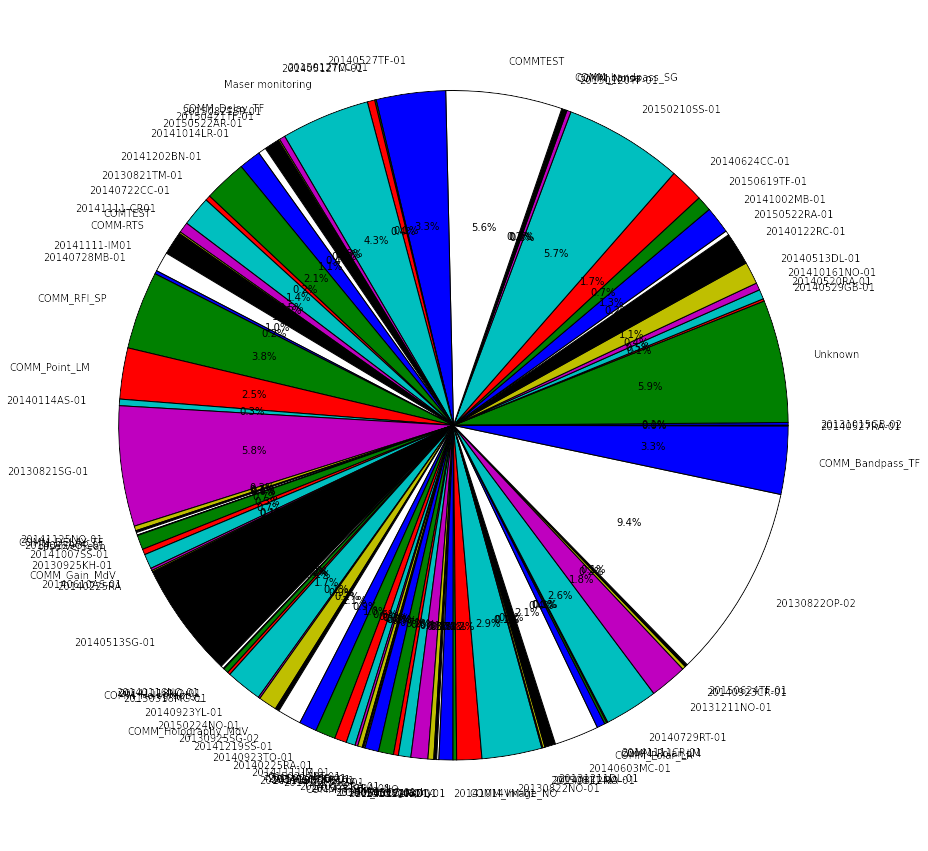

In [63]:
plt.figure(figsize=(15,15))
plt.pie(a_time,labels=a_id,autopct='%1.1f%%');

In [64]:
plt.show()

In [65]:
print f[9].metadata.Details[306:381]


served from 2015-08-30 11:13:57.746 SAST to 2015-08-30 11:15:41.754 SAST
Du


In [66]:
print len(f[11].metadata.Antennas)
print ants

4
[4 4 4 ..., 5 5 6]


In [67]:
print f[234].metadata.InstructionSet

/home/kat/scripts/observation/auto_attenuate.py -f 1822 -t radec,0,-90 --mode=bc16n400M1k --proposal-id=COMM_Atten --program-block-id=362ob499095754 --sb-id-code=20150807-0007 --description= AutoAttenuation for 362ob499095754  --observer=operator


In [68]:
print ants.min(),ants.max()

1 7


In [69]:
print len(ants), len(du)

2387 2387


In [70]:
hours_ant=np.zeros(7)
for n in range(len(ants)):
    #print pid[n],ants[n], du[n]/3600.
    hrs=du[n]/3600
    for nrants in range(ants.min(), ants.max()+1): 
        if ants[n] == nrants:
            #print n, hrs
            hours_ant[nrants-1] += hrs
            
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float':'{:7.2f}'.format})
print "Hours with n antennas (1-7)",  hours_ant.view(dtype=np.float)
            

Hours with n antennas (1-7) [  19.99   36.53    4.33  187.55 1661.61 3523.59 5716.51]


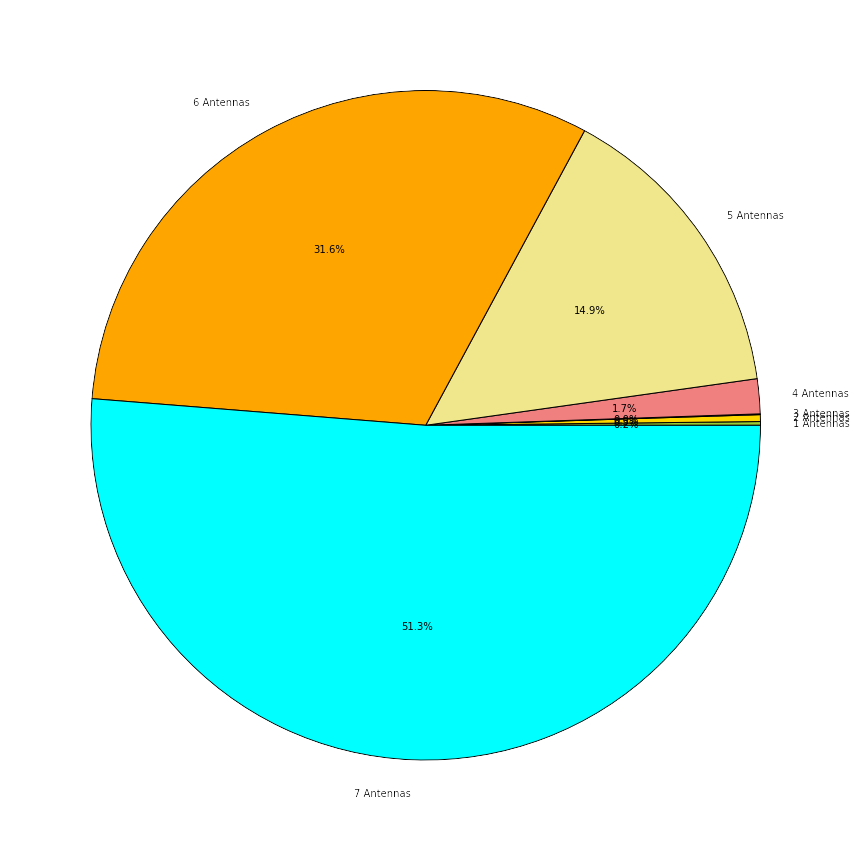

In [71]:
labs=[]
for n in range(7):
    labs.append(str(n+1)+" Antennas")

#cmap = plt.cm.prism
#colors = cmap(np.linspace(0., 1., 7))
colors=['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','khaki','orange','cyan']
y=hours_ant
plt.figure(figsize=(15,15))
plt.pie(y,labels=labs,colors=colors, autopct='%1.1f%%')
plt.show()